# Imports

In [ ]:
!pip uninstall deepdowmine -y
!pip install git+https://github.com/dsman1823/deepdowmine.git

In [1]:
import numpy as np
import pandas as pd
import torch

from matplotlib import pyplot as plt
from deepdowmine.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale, SeqRigidDataLoader, WeeklyRigidDataLoader
from deepdowmine.losses import MeanReturns, SharpeRatio, MaximumDrawdown, StandardDeviation
from deepdowmine.nn import DenseNetFullOpti2, DenseNetMinVar2
from deepdowmine.experiments import Run
from deepdowmine.callbacks import EarlyStoppingCallback
from deepdowmine.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap




# Setup

In [16]:
np.random.seed(5)
returns = pd.read_csv('old_train_data_2.csv', index_col = 0).to_numpy()[1:]

In [17]:
len(returns)

3259

In [18]:
n_timesteps, n_assets = len(returns), 5#11**4, 450

#returns = np.random.normal(0, .2, size = (n_timesteps, n_assets))

lookback, gap, horizon = 50, 0, 5# 40, 0, 5   loss=-0.09645, test_loss=-0.08003]
n_samples = n_timesteps - lookback - horizon - gap + 1

indices = np.arange(n_samples)
split_ix = int(n_samples * 0.8)
indices_train = indices[:split_ix]
indices_test = indices[split_ix:]


# print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
#                                                      indices_test[0], indices_test[-1]))

In [19]:
def transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap):
    X_list, y_list = [], []

    for i in range(lookback, n_timesteps - horizon - gap + 1):
        X_list.append(returns[i - lookback: i, :])
        y_list.append(returns[i + gap: i + gap + horizon, :])

    X = np.stack(X_list, axis=0)[:, None, ...]
    y = np.stack(y_list, axis=0)[:, None, ...]

    return X, y

In [20]:

#returns = np.random.normal(0, .2, size = (n_timesteps, n_assets))

# X_list, y_list = [], []

# for i in range(lookback, n_timesteps - horizon - gap + 1):
#     X_list.append(returns[i - lookback: i, :])
#     y_list.append(returns[i + gap: i + gap + horizon, :])

# X = np.stack(X_list, axis=0)[:, None, ...]
# y = np.stack(y_list, axis=0)[:, None, ...]
X, y = transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap)
#print('X: {}, y: {}'.format(X.shape, y.shape))

# means, stds = prepare_standard_scaler(X, indices=indices_train)
# print('mean: {}, std: {}'.format(means, stds))

dataset = InRAMDataset(X, y)
#, transform=Scale(means, stds))

torch.manual_seed(32)

dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

dataloader_test = SeqRigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)

dataloader_train_for_retrain = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)
dataloader_test_for_retrain = SeqRigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)


# Network setup

In [21]:
network = DenseNetMinVar2(1, 50, 5,  max_weight=1, p=0.2)
print(network)
network = network.train()
loss = SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={
              'test': dataloader_test,
              'train': dataloader_train
              },
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)]) #15 # patience controlls amount offffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffrfvd

DenseNetMinVar2(
  (norm_layer): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (linear_for_cov): Linear(in_features=250, out_features=750, bias=True)
  (covariance_layer): CovarianceMatrix()
  (portfolio_opt_layer): ThesisMarkowitzMinVar(
    (cvxpylayer): CvxpyLayer()
  )
)


# Train start

In [22]:
history = run.launch(450)
torch.save(network.state_dict(), 'network.pth')


Epoch 0:   0%|                                                                                  | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 0:  38%|██████████████████████▏                                   | 31/81 [00:13<00:20,  2.40it/s, loss=-0.07156]


Epoch 0:  79%|█████████████████████████████████████████████▊            | 64/81 [00:27<00:07,  2.39it/s, loss=-0.07644]


Epoch 0: 100%|█████████████████| 81/81 [01:04<00:00,  1.27it/s, loss=-0.07469, test_loss=-0.11130, train_loss=-0.15257]

Epoch 1:   0%|                                                                                  | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 1:  15%|████████▌                                                 | 12/81 [00:05<00:29,  2.30it/s, loss=-0.18187]


Epoch 1:  56%|████████████████████████████████▏                         | 45/81 [00:21<00:17,  2.06it/s, loss=-0.14168]


Epoch 1:  96%|███████████████████████████████████████████████████████▊  | 78/81 [00:37<00:01,  2.08it/s, loss=-0.14407]


Epoch 1: 100%|█████████████████| 81/81 [01:13<00:00,  1.10it/s, loss=-0.14272, test_loss=-0.18350, train_loss=-0.24033]

Epoch 2:   0%|                                                                                  | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 2:  33%|███████████████████▎                                      | 27/81 [00:14<00:26,  2.03it/s, loss=-0.22583]


Epoch 2:  74%|██████████████████████████████████████████▉               | 60/81 [00:34<00:10,  2.01it/s, loss=-0.21309]


Epoch 44: 100%|█████████████████████████████████████████████████████████| 68/68 [03:54<00:00,  3.45s/it, loss=-0.75081]

Epoch 3:   0%|                                                                                  | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 4:   0%|                                                                                  | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found I

Epoch 7:   0%|                                                                                  | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 8:   0%|                                                                                  | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 18:   0%|                                                                                 | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 19:   0%|                                                                                 | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 29:   0%|                                                                                 | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 30:   0%|                                                                                 | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 40:   0%|                                                                                 | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 41:   0%|                                                                                 | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 51:   0%|                                                                                 | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 52:   0%|                                                                                 | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 62:   0%|                                                                                 | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 63:   0%|                                                                                 | 0/81 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Training interrupted
Training stopped early because there was no improvement in test_loss for 15 epochs


## Retrain the model on validation set with limited amount of epochs, and limited learning rate

In [23]:
network_retrained = DenseNetMinVar2(1, 50, 5,  max_weight=1, p=0.2)
network_retrained.load_state_dict(network.state_dict())

##!!!!!!!!!!!!!!!!!!!!!!!!
# state_dict = torch.load('min_var_0.pth')
# network_retrained.load_state_dict(state_dict)
# ####


print(network_retrained)
network_retrained = network_retrained.train()
loss = SharpeRatio()
run = Run(network_retrained,
          loss,
          dataloader_train_for_retrain,
          val_dataloaders={
              'train': dataloader_train_for_retrain,
              'test': dataloader_test_for_retrain
              },
          optimizer=torch.optim.Adam(network_retrained.parameters(), amsgrad=True, lr=0.0005),
)

DenseNetMinVar2(
  (norm_layer): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (linear_for_cov): Linear(in_features=250, out_features=750, bias=True)
  (covariance_layer): CovarianceMatrix()
  (portfolio_opt_layer): ThesisMarkowitzMinVar(
    (cvxpylayer): CvxpyLayer()
  )
)


In [24]:
history_retrain = run.launch(30)
torch.save(network_retrained.state_dict(), 'network_retrained.pth')

Epoch 0:   0%|                                                                                  | 0/21 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 0:  95%|███████████████████████████████████████████████████████▏  | 20/21 [00:11<00:00,  1.35it/s, loss=-0.12249]

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 250])

# Check model perfomance

In [ ]:
  # network = LstmNetMinVar(5)
  # network.load_state_dict(torch.load(fr'network_2.pth'))

In [28]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

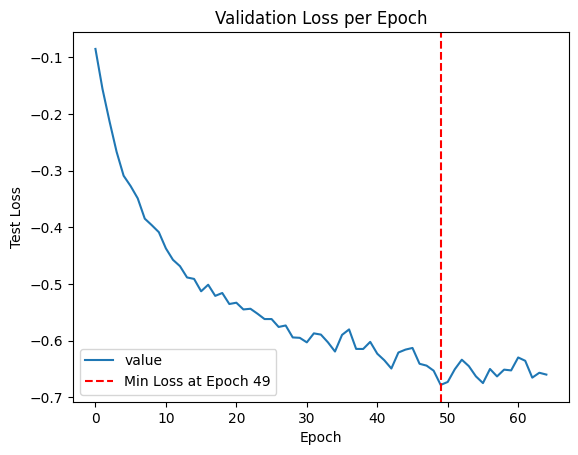

In [29]:
mean_test_loss = per_epoch_results.mean()['test']['loss']['network'] # tmp

# Plotting the mean test loss per epoch
mean_test_loss.plot()

# Finding the epoch with the minimum test loss
min_loss_epoch = mean_test_loss.idxmin()
min_loss_value = mean_test_loss.min()

# Adding a red vertical line at the epoch with minimum test loss
plt.axvline(x=min_loss_epoch, color='r', linestyle='--', label=f'Min Loss at Epoch {min_loss_epoch}')

# Adding some labels and title for clarity
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Show the plot
plt.show()

In [ ]:
per_epoch_results.mean()['test']['loss']['network'].mean()

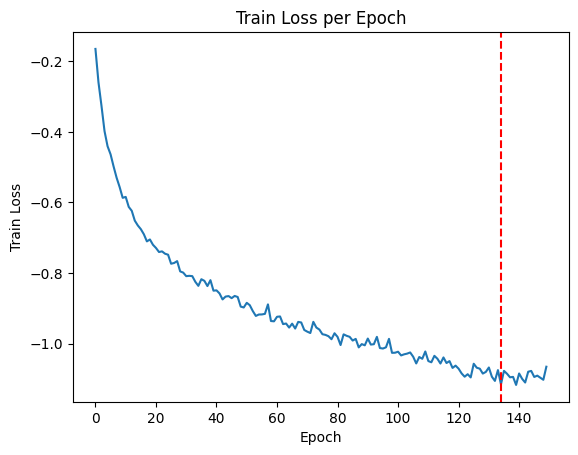

In [15]:
mean_train_loss = per_epoch_results.mean()['train']['loss']['network']

# Plotting the mean test loss per epoch
mean_train_loss.plot()



# Adding some labels and title for clarity
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss per Epoch')
plt.axvline(x=min_loss_epoch, color='r', linestyle='--', label=f'The best model {min_loss_epoch}')

# Show the plot
plt.show()

In [30]:
from deepdowmine.benchmarks import Benchmark, OneOverN, Random

benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'network': network
}

metrics = {
    'Sharpe': SharpeRatio(),
}


metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics
)

C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [31]:
metrics_table[metrics_table['benchmark'] == 'network']['value'].mean() / metrics_table[metrics_table['benchmark'] == '1overN']['value'].mean()

45.549263

In [ ]:
metrics_table[metrics_table['benchmark'] == '1overN']['value'].mean()

In [ ]:
metrics_table[metrics_table['benchmark'] == 'network']['value'].mean()

In [ ]:
len(indices_test)

In [ ]:
one_over_n = metrics_table[metrics_table['benchmark'] == '1overN']['value']

In [ ]:
np.array(one_over_n)[indices_test]

In [ ]:
# Filter the DataFrame for the two conditions
one_over_n = -metrics_table[metrics_table['benchmark'] == '1overN']['value']
network_res = -metrics_table[metrics_table['benchmark'] == 'network']['value']


x_axis = np.arange(len(one_over_n))  # This will create an array [0, 1, ..., n-1]

plt.figure(figsize=(10, 6))

# Plot each series on the same plot
plt.plot(x_axis, one_over_n, label='1overN', marker='o', linestyle='-')
plt.plot(x_axis, network_res, label='Network', marker='x', linestyle='-')

# Adding titles and labels
plt.title('Sharpe Ratio Comparison')
plt.xlabel('Index')
plt.ylabel('Sharpe Ratio')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
network_res

In [ ]:
metrics_table[metrics_table['benchmark'] == 'network']['value'].mean()

In [ ]:
history = run.launch(450)
torch.save(network.state_dict(), 'network_2.pth')

# Load the results

In [ ]:
network = LinearNetMine(1, lookback, n_assets, p=0.5)
network.load_state_dict(torch.load('linear_net_50x5_sharpe.pth'))

# Supplementary code

In [ ]:
# 1.363

In [ ]:
X.shape

In [ ]:
test_X = torch.tensor(X[[-1]], dtype=torch.float32)#(X[indices_train], dtype=torch.float32) #indices_train
test_X.shape

In [ ]:
def get_activation(name):
    # This function will return a hook function that stores the output in a dictionary
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Attach the hook to the covariance_layer, which precedes the channel_collapse_layer
activations = {}
hook = network.portfolio_opt_layer.register_forward_hook(get_activation('portfolio_opt_layer'))

# Now run your data through the network. This will store the output of the covariance_layer in activations
network(test_X)

# The output you're interested in is now stored in activations['covariance_layer_output']
input_to_channel_collapse = activations['portfolio_opt_layer']

# Don't forget to remove the hook when you're done to prevent memory leaks
hook.remove()

In [ ]:
input_to_channel_collapse.shape

In [ ]:
network(test_X).shape